# TRACT Analysis notebook
## Soumya Prakash Behera, modified 10/13/2021
### Barrick Lab, Johns Hopkins University
#### email: sbehera3@jhu.edu

This script requires nmrglue package to be installed with the python running in your kernel, more information about installing nmrglue can be found at:
https://nmrglue.readthedocs.io/en/latest/install.html



In [1]:
import numpy as np
import nmrglue as ng
import matplotlib.pyplot as plt
import sys
import subprocess
import re
from scipy.optimize import curve_fit

Only make changes to the parameters in the following cell

In [10]:
# trosy_data_directory = '../nmrData/CTXM9/20210929_CTXM9_C69A_NH_TRACT_TROSY_25' # Directory with TROSY Datasets
# anti_trosy_data_directory = '../nmrData/CTXM9/20210929_CTXM9_C69A_NH_Anti_TROSY_25' # Directory with Anti TROSY Datasets

trosy_data_directory = '../nmrData/cAK/20210712_cAK_apo_TRACT_TROSY_datacollect' # Directory with TROSY Datasets
anti_trosy_data_directory = '../nmrData/cAK/20210712_cAK_apo_TRACT_AntiTROSY_datacollect' # Directory with Anti TROSY Datasets

B0_MHz = 600.55 # spec freq MHz
start = 6.2 # start ppm for integration
end = 7.5 # end ppm for integration

delay_number = 7  # D7: parameter that sets relaxation delay ################## DO NOT CHANGE unless there is change to the pulse sequence ##################

In [3]:
def readDelays(params,delay_number):        
    return params['acqus']['D'][delay_number]

def extractDataInPipe(data_directory,delay_number):
    exp_data = {}
    exp_data['params'] = []
    exp_data['fids'] = []
    exp_data['iterator'] = []
    exp_data['fid_length'] = []
    
    exp_nos = subprocess.getoutput("ls {0}".format(data_directory))
    exp_nos = exp_nos.split("\n")
    exp_nos.sort(key=lambda f: int(re.sub('\D', '', f)))
    nos = np.arange(len(exp_nos))
    for i in exp_nos:
        param, fid = ng.fileio.bruker.read_pdata(data_directory+'/'+i+'/pdata/1', read_acqus = True, read_procs= True)
        C = ng.convert.converter()
        C.from_bruker(param, fid)
        pparam, pfid = C.to_pipe()
        exp_data['params'].append(pparam)
        exp_data['fids'].append(pfid)
        exp_data['iterator'].append(readDelays(param,delay_number))
        exp_data['fid_length'].append(pfid.shape[0])
    
    return exp_data


/Users/soumyaprakashbehera/anaconda3/lib/python3.8/site-packages/nmrglue/fileio/convert.py:68: UserWarning: Incompatible dtypes, conversion not recommended
  warn("Incompatible dtypes, conversion not recommended")
/Users/soumyaprakashbehera/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/soumyaprakashbehera/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


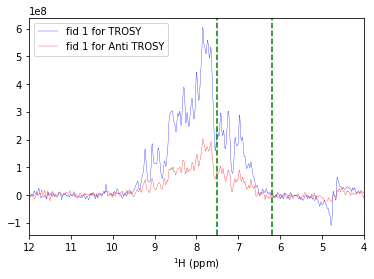

In [11]:

trosy_exp_data = extractDataInPipe(trosy_data_directory, delay_number)
anti_trosy_exp_data = extractDataInPipe(anti_trosy_data_directory, delay_number)

# determind the ppm scale
uc = ng.pipe.make_uc(trosy_exp_data['params'][0], trosy_exp_data['fids'][0])
ppm_scale = uc.ppm_scale()

# integrate the fids

min = uc(start, "ppm")
max = uc(end, "ppm")
if min > max:
    min, max = max, min

trosy_exp_data['fid_area'] = []
anti_trosy_exp_data['fid_area'] = []
# extract trosy regions
# t = 0
for i in trosy_exp_data['fids']:
    trosy_region = i[min:max + 1]
    trosy_exp_data['fid_area'].append(trosy_region.sum())
    
for j in anti_trosy_exp_data['fids']:
    anti_trosy_region = j[min:max + 1]
    anti_trosy_exp_data['fid_area'].append(anti_trosy_region.sum())
    
# plot the spectrum
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ppm_scale, trosy_exp_data['fids'][0], 'b-', linewidth = 0.3)
ax.plot(ppm_scale, anti_trosy_exp_data['fids'][0], 'r-', linewidth = 0.3)
ax.set_xlim([4.0,12])

plt.xlabel('$^{1}$H (ppm)')
plt.legend(['fid 1 for TROSY', 'fid 1 for Anti TROSY'])



peak_scale = ppm_scale[min:max + 1]
# ax.plot(peak_scale, [0] * len(peak_scale), 'g-', linewidth = 2)
ax.axvline(x = peak_scale[0], color ='g', linestyle = '--')
ax.axvline(x = peak_scale[-1], color ='g', linestyle = '--')
ax.invert_xaxis()

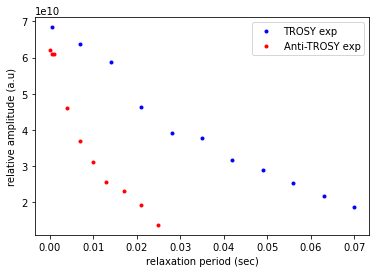

In [13]:
# anti_trosy_exp_data['fid_area']

plt.plot(trosy_exp_data['iterator'], trosy_exp_data['fid_area'],'.b')
plt.plot(anti_trosy_exp_data['iterator'], anti_trosy_exp_data['fid_area'],'.r')
plt.xlabel('relaxation period (sec)')
plt.ylabel('relative amplitude (a.u)')
plt.legend(['TROSY exp','Anti-TROSY exp'])


In [6]:
def exp_func(x,R):
    return np.exp(-R*(x))

# initial_guess = np.array([50, 0.1, 0.01, 0.001])
pred_Ralpha, r2a = curve_fit(exp_func, trosy_exp_data['iterator'], trosy_exp_data['fid_area']/np.max(trosy_exp_data['fid_area']))
pred_Rbeta, r2b = curve_fit(exp_func, anti_trosy_exp_data['iterator'], anti_trosy_exp_data['fid_area']/np.max(anti_trosy_exp_data['fid_area']))

/Users/soumyaprakashbehera/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/soumyaprakashbehera/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


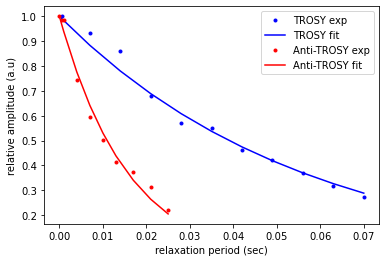

In [7]:
plt.plot(trosy_exp_data['iterator'], trosy_exp_data['fid_area']/np.max(trosy_exp_data['fid_area']),'.b')
x_trosy_sorted = trosy_exp_data['iterator']
x_trosy_sorted.sort()
plt.plot(trosy_exp_data['iterator'], exp_func(np.array(x_trosy_sorted), pred_Ralpha[0]),'b')

plt.plot(anti_trosy_exp_data['iterator'], anti_trosy_exp_data['fid_area']/np.max(anti_trosy_exp_data['fid_area']),'.r')
x_anti_trosy_sorted = anti_trosy_exp_data['iterator']
x_anti_trosy_sorted.sort()
plt.plot(anti_trosy_exp_data['iterator'], exp_func(np.array(x_anti_trosy_sorted), pred_Rbeta[0]),'r')
plt.xlabel('relaxation period (sec)')
plt.ylabel('relative amplitude (a.u)')
plt.legend(['TROSY exp', 'TROSY fit', 'Anti-TROSY exp', 'Anti-TROSY fit'])



In [8]:

h = 6.62607004 * 1e-34
mu0 = 1.25663706 * 1e-6
gamma_H = 267.52218744 * 1e6
gamma_N = -27.116 * 1e6
r = 1.02 * 1e-10
del_del_N = 160 * 1e-6
theta = 24 * (np.pi/180)
B0 = (2 * np.pi) * B0_MHz * 1e6 / gamma_H
omega_N = gamma_N * B0

p = (mu0 * gamma_H * gamma_N * h) / (16 * (np.pi)**2 * np.sqrt(2) * r**3)
del_N = (gamma_N * B0 * del_del_N)/ (3 * np.sqrt(2))
c =  (pred_Rbeta[0] - pred_Ralpha[0])/(2 * p * del_N * (3 * (np.cos(theta))**2 - 1))

coeff = [8 * (omega_N)**2, -5 * c * (omega_N)**2, 14, -5 * c ]
tau_c = np.roots(coeff)

tau_c_real = tau_c[np.isreal(tau_c)] * 1e9
# tau_c_real
calc_mol_wt = 2* tau_c_real
print("Relaxation rate for TROSY component = {0:2.3f} Hz \nRelaxation rate for Anti TROSY component = {1:2.3f} Hz".format(pred_Ralpha[0], pred_Rbeta[0]))
print("The calculated rotational correlation time is {0:3.3f} ns\nThe calculated molecular weight is {1:3.3f} KDa".format(tau_c_real[0].real,calc_mol_wt[0].real))

Relaxation rate for TROSY component = 17.758 Hz 
Relaxation rate for Anti TROSY component = 63.399 Hz
The calculated rotational correlation time is 25.604 ns
The calculated molecular weight is 51.207 KDa


In [9]:
    
# # plot the integration lines, limits and name of peaks
# peak_scale = ppm_scale[min:max + 1]
# ax.plot(peak_scale, peak.cumsum() / 100. + peak.max(), 'g-')
# ax.plot(peak_scale, [0] * len(peak_scale), 'r-')
# ax.text(peak_scale[0], 0.5 * peak.sum() / 100. + peak.max(), name,
#             fontsize=8)

# # write out the integration info
# tup = (name, peak_scale[0], peak_scale[-1], peak.sum())
# # f.write("%s\t%.3f\t%.3f\t%E\n" % tup)

# # close the output file and save the plot
# # f.close()
# # ax.set_xlim(ppm_scale[0], ppm_scale[-1])